# CS4248 Project
(DON'T CLICK RUN ALL! Lemmatization takes tooo long and pls don't run it again)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# 
# %cd "/content/drive/My Drive/CS4248 Project"
# !cd "/content/drive/My Drive/CS4248 Project"

%pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [62]:
import pandas as pd
import numpy as np
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_extraction.text import TfidfVectorizer
import datetime
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import os
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_filename='glove.6B.100d.txt'
# If you are running for the first time, uncomment the below 2 lines
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip
glove_path = os.path.abspath(os.path.join('.', glove_filename))

word2vec_output_file = glove_filename+'.word2vec'

glove2word2vec(glove_path, word2vec_output_file)
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
/var/folders/j2/q86pqgyn7bz6wlqds1ml4h_40000gn/T/ipykernel_94233/2747738669.py:28: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_file)


In [3]:
csv.field_size_limit(999999)
train = pd.read_csv('raw_data/fulltrain.csv', header = None, names=['class','text'])
X_train = train['text']
y_train = train['class']

In [4]:
train.head()

,class,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [66]:
test = pd.read_csv("raw_data/balancedtest.csv", header = None, names=['class','text'])
X_test = test['text']
y_test = test['class']

In [6]:
test.head()

,class,text
0,1,When so many actors seem content to churn out ...
1,1,In what football insiders are calling an unex...
2,1,In a freak accident following Game 3 of the N....
3,1,North Koreas official news agency announced to...
4,1,The former Alaska Governor Sarah Palin would b...


In [78]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder()
y_train_labeled = one_hot_encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test_labeled = one_hot_encoder.transform(np.array(y_test).reshape(-1, 1)).toarray()


## Baseline Models

In [70]:
def tfidf(X_train, X_test):

  tfidf_baseline = TfidfVectorizer(ngram_range=(1,1), max_features = 10000)

  X_train_tfidf = tfidf_baseline.fit_transform(X_train)

  X_test_tfidf = tfidf_baseline.transform(X_test)

  return X_train_tfidf, X_test_tfidf

X_train_tfidf, X_test_tfidf = tfidf(X_train, X_test)

In [74]:
# Logistic Regression - baseline

def LR(X_train_tfidf, y_train, X_test_tfidf, y_test):
  print("Training start: ", datetime.datetime.now())

  LR_classifier = LogisticRegression(random_state = 42, max_iter=2000).fit(X_train_tfidf, y_train)

  y_pred_lr = LR_classifier.predict(X_test_tfidf)

  print(classification_report(y_test, y_pred_lr))
  print("Training finish: ", datetime.datetime.now())

  return y_pred_lr

y_pred_lr = LR(X_train_tfidf, y_train, X_test_tfidf, y_test)

Training start:  2024-04-12 22:22:54.117954
              precision    recall  f1-score   support

           1       0.85      0.79      0.82       750
           2       0.82      0.38      0.52       750
           3       0.57      0.83      0.67       750
           4       0.80      0.92      0.86       750

    accuracy                           0.73      3000
   macro avg       0.76      0.73      0.72      3000
weighted avg       0.76      0.73      0.72      3000

Training finish:  2024-04-12 22:23:04.228760


In [53]:
# NB - baseline

def NB(X_train_tfidf, y_train, X_test_tfidf, y_test):

  nb_classifier = ComplementNB().fit(X_train_tfidf, y_train)

  y_pred_nb = nb_classifier.predict(X_test_tfidf)

  print(classification_report(y_test, y_pred_nb))

  return y_pred_nb

y_pred_nb = NB(X_train_tfidf, y_train, X_test_tfidf, y_test)

              precision    recall  f1-score   support

           1       0.62      0.61      0.62       750
           2       0.62      0.46      0.53       750
           3       0.62      0.93      0.74       750
           4       0.88      0.67      0.76       750

    accuracy                           0.67      3000
   macro avg       0.68      0.67      0.66      3000
weighted avg       0.68      0.67      0.66      3000



## Preprocessing

### Lemmatization with POS Tagging
(DON'T RUN AGAIN! It takes tooooo long)

In [54]:
# WORDNET LEMMATIZER (with appropriate pos tags)
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

# Define function to lemmatize each word with its POS tag

# POS_TAGGER_FUNCTION : TYPE 1
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_with_pos(tokens):
  # tokenize the sentence and find the POS tag for each token
  pos_tagged = nltk.pos_tag(tokens)

  # print(pos_tagged)

  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
  # print(wordnet_tagged)
tqmd
  lemmatized_sentence = []
  for word, tag in wordnet_tagged:
      if tag is None:
          # if there is no available tag, append the token as is
          lemmatized_sentence.append(word)
      else:
          # else use the tag to lemmatize the token
          lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
  # lemmatized_sentence = " ".join(lemmatized_sentence)

  # print(lemmatized_sentence)
  return lemmatized_sentence

[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:997)>


In [136]:
# Start preprocessing

from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
from tqdm import tqdm
from spellchecker import SpellChecker

punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

spell = SpellChecker()

def preprocessing(data):
  data_clean = []
  for sentence in tqdm(data):

    # Tokenization
    tokens = word_tokenize(sentence)

    # Remove punctuation and number
    tokens = [w for w in tokens if (not w in punc) and (not w.isdigit())]

    # Spell check
    # Taking too long time for each sentence, not practical to be used
    # tokens = [spell.correction(w) for w in tokens]
    # tokens = [w for w in tokens if w is not None and len(w) > 0]

    # Lemmatization based on tagging
    tokens = lemmatize_with_pos(tokens)

    data_clean.append((' ').join(tokens))
  return data_clean

X_train_clean = preprocessing(X_train)
X_test_clean = preprocessing(X_test)

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [79]:
import csv
import pandas as pd

def write_to_csv(X_train_clean, X_test_clean):
    with open('raw_data/X_train_clean.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        for doc in X_train_clean:
            writer.writerow([doc])

    with open('raw_data/X_test_clean.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        for doc in X_test_clean:
            writer.writerow([doc])

# Uncomment if you want to save X_train_clean and X_test_clean
# write_to_csv(X_train_clean, X_test_clean)

In [72]:
def read_from_file():
    a_df = pd.read_csv('raw_data/X_train_clean.csv', header=None, dtype=str)
    a = a_df[0].values
    
    b_df = pd.read_csv('raw_data/X_test_clean.csv', header=None, dtype=str)
    b = b_df[0].values
    return a, b

# Uncomment if you want to read from file
a, b = read_from_file()
X_train_clean, X_test_clean = a, b

In [75]:
X_train_clean_tfidf, X_test_clean_tfidf = tfidf(X_train_clean, X_test_clean)

_ = LR(X_train_clean_tfidf, y_train, X_test_clean_tfidf, y_test)

Training start:  2024-04-12 22:23:18.002467
              precision    recall  f1-score   support

           1       0.85      0.81      0.83       750
           2       0.84      0.42      0.56       750
           3       0.59      0.83      0.69       750
           4       0.81      0.91      0.86       750

    accuracy                           0.74      3000
   macro avg       0.77      0.74      0.73      3000
weighted avg       0.77      0.74      0.73      3000

Training finish:  2024-04-12 22:23:25.734661


In [82]:
_ = NB(X_train_clean_tfidf, y_train, X_test_clean_tfidf, y_test)

              precision    recall  f1-score   support

           1       0.60      0.61      0.61       750
           2       0.65      0.51      0.57       750
           3       0.63      0.92      0.75       750
           4       0.87      0.64      0.74       750

    accuracy                           0.67      3000
   macro avg       0.69      0.67      0.67      3000
weighted avg       0.69      0.67      0.67      3000


In [63]:
class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('queen')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D*3))
    n = 0
    emptycount = 0
    for sentence in tqdm(data):
      tokens = nltk.word_tokenize(sentence.lower())
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = np.concatenate((vecs.mean(axis=0), vecs.min(axis=0), vecs.max(axis=0)))
      else:
        emptycount += 1
      n += 1
    print("Number of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

In [64]:
word2vec_vectorizer = Word2VecVectorizer(word2vec_model)
X_train_word2vec = word2vec_vectorizer.fit_transform(X_train)

Loading in word vectors...
Finished loading in word vectors


100%|█████████████████████████████████████████████████████████████████████████| 48854/48854 [03:25<00:00, 237.16it/s]

Number of samples with no words found: 2 / 48854


In [67]:
# apply to test
X_test_word2vec = word2vec_vectorizer.fit_transform(X_test)

100%|███████████████████████████████████████████████████████████████████████████| 3000/3000 [00:11<00:00, 261.44it/s]

Number of samples with no words found: 0 / 3000


In [76]:
X_train_combined = np.concatenate((X_train_clean_tfidf.toarray(), X_train_word2vec), axis=1)
# X_train_combined =  X_train_word2vec
print(X_train_clean_tfidf.shape)
print(X_train_word2vec.shape)
print(X_train_combined.shape)

X_test_combined = np.concatenate((X_test_clean_tfidf.toarray(), X_test_word2vec), axis=1)
# X_test_combined =  X_test_word2vec

(48854, 10000)
(48854, 300)
(48854, 10300)


## NN

### Approach 1:

### td-idf + glove embedding

In [81]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam,Adagrad
import tensorflow_addons as tfa
from keras import regularizers

epochs = 10

model = Sequential()
model.add(Dense(256, activation='sigmoid', input_shape=(X_train_combined.shape[1],)))
model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy', tfa.metrics.F1Score(average='macro',num_classes=4)])
model.summary()

checkpoint_filepath = 'checkpoint_model_nn1'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_f1_score',
    mode='max',
    save_best_only=True)

model.fit(X_train_combined, y_train_labeled, epochs=epochs, validation_data=(X_test_combined, y_test_labeled),\
          callbacks=[model_checkpoint_callback])

model.load_weights(checkpoint_filepath)

y_pred = model.predict(X_test_combined)

y_pred_inverse = one_hot_encoder.inverse_transform(y_pred)

print(classification_report(y_test, y_pred_inverse))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               2637056   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 516       
                                                                 
Total params: 2670468 (10.19 MB)
Trainable params: 2670468 (10.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
152

INFO:tensorflow:Assets written to: checkpoint_model_nn1/assets


1527/1527 [==============================] - 40s 26ms/step - loss: 0.6368 - accuracy: 0.7446 - f1_score: 0.7186 - val_loss: 1.1281 - val_accuracy: 0.6380 - val_f1_score: 0.6197
Epoch 2/10
1526/1527 [============================>.] - ETA: 0s - loss: 0.2122 - accuracy: 0.9258 - f1_score: 0.9197INFO:tensorflow:Assets written to: checkpoint_model_nn1/assets


INFO:tensorflow:Assets written to: checkpoint_model_nn1/assets


1527/1527 [==============================] - 37s 24ms/step - loss: 0.2122 - accuracy: 0.9258 - f1_score: 0.9197 - val_loss: 0.7475 - val_accuracy: 0.7430 - val_f1_score: 0.7392
Epoch 3/10
1527/1527 [==============================] - 38s 25ms/step - loss: 0.1421 - accuracy: 0.9503 - f1_score: 0.9468 - val_loss: 0.8309 - val_accuracy: 0.7280 - val_f1_score: 0.7245
Epoch 4/10
1527/1527 [==============================] - 38s 25ms/step - loss: 0.1116 - accuracy: 0.9616 - f1_score: 0.9591 - val_loss: 1.1550 - val_accuracy: 0.6730 - val_f1_score: 0.6631
Epoch 5/10
1525/1527 [============================>.] - ETA: 0s - loss: 0.0912 - accuracy: 0.9679 - f1_score: 0.9659INFO:tensorflow:Assets written to: checkpoint_model_nn1/assets


INFO:tensorflow:Assets written to: checkpoint_model_nn1/assets


1527/1527 [==============================] - 38s 25ms/step - loss: 0.0912 - accuracy: 0.9679 - f1_score: 0.9659 - val_loss: 0.8959 - val_accuracy: 0.7567 - val_f1_score: 0.7492
Epoch 6/10
1527/1527 [==============================] - 38s 25ms/step - loss: 0.0800 - accuracy: 0.9728 - f1_score: 0.9711 - val_loss: 1.3412 - val_accuracy: 0.7123 - val_f1_score: 0.6922
Epoch 7/10
1527/1527 [==============================] - 39s 25ms/step - loss: 0.0708 - accuracy: 0.9755 - f1_score: 0.9740 - val_loss: 1.2963 - val_accuracy: 0.7183 - val_f1_score: 0.6946
Epoch 8/10
1527/1527 [==============================] - 39s 25ms/step - loss: 0.0627 - accuracy: 0.9785 - f1_score: 0.9773 - val_loss: 0.9285 - val_accuracy: 0.7493 - val_f1_score: 0.7414
Epoch 9/10
1526/1527 [============================>.] - ETA: 0s - loss: 0.0553 - accuracy: 0.9815 - f1_score: 0.9803INFO:tensorflow:Assets written to: checkpoint_model_nn1/assets


INFO:tensorflow:Assets written to: checkpoint_model_nn1/assets


1527/1527 [==============================] - 41s 27ms/step - loss: 0.0553 - accuracy: 0.9815 - f1_score: 0.9803 - val_loss: 0.8824 - val_accuracy: 0.7753 - val_f1_score: 0.7726
Epoch 10/10
1527/1527 [==============================] - 39s 26ms/step - loss: 0.0512 - accuracy: 0.9820 - f1_score: 0.9808 - val_loss: 1.0534 - val_accuracy: 0.7413 - val_f1_score: 0.7374


2024-04-12 22:49:35.528031: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open checkpoint_model_nn1: FAILED_PRECONDITION: checkpoint_model_nn1; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


94/94 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           1       0.84      0.79      0.81       750
           2       0.74      0.58      0.65       750
           3       0.67      0.82      0.74       750
           4       0.87      0.91      0.89       750

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.77      3000
weighted avg       0.78      0.78      0.77      3000



In [90]:
layer_name = 'dense_10'
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model(X_test_combined)
intermediate_output

<tf.Tensor: shape=(3000, 128), dtype=float32, numpy=
array([[0.00110151, 0.8386019 , 0.90150696, ..., 0.23704822, 0.0017399 ,
        0.00120609],
       [0.00395824, 0.81317914, 0.8740999 , ..., 0.21737298, 0.00104289,
        0.00431592],
       [0.03128602, 0.6159007 , 0.4279891 , ..., 0.35501117, 0.00111151,
        0.03165342],
       ...,
       [0.25903714, 0.04194087, 0.04392021, ..., 0.00470304, 0.00767467,
        0.33156297],
       [0.6086316 , 0.04851189, 0.01383203, ..., 0.01982741, 0.00897613,
        0.61016136],
       [0.1505597 , 0.02509742, 0.01740577, ..., 0.00660846, 0.15116191,
        0.1859482 ]], dtype=float32)>

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

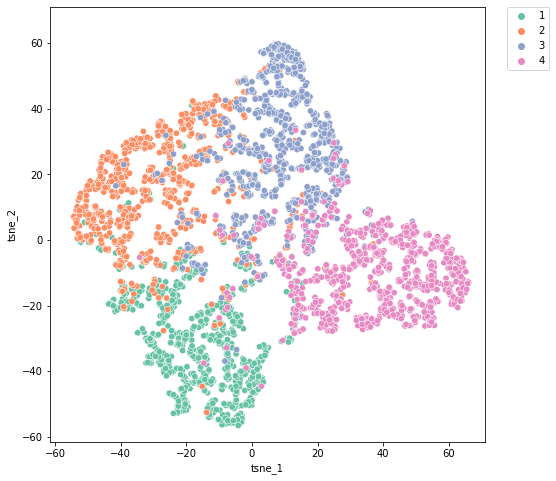

In [107]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(intermediate_output)
tsne_result.shape
# (3000, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y_test})
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', palette="Set2", data=tsne_result_df, ax=ax,s=40)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

1527/1527 [==============================] - 6s 4ms/step
Confusion matrix for training dataset
 [[14007    16    23     1]
 [    3  6934     5     0]
 [   22    41 17803     4]
 [  209     9    34  9743]]


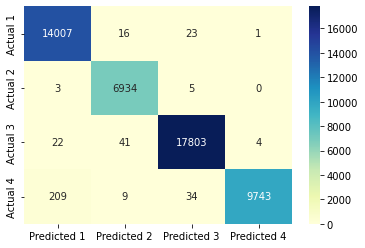

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_train_combined)
y_pred_inverse = one_hot_encoder.inverse_transform(y_pred)
cm = confusion_matrix(y_train, y_pred_inverse)

print('Confusion matrix for training dataset\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Predicted 1', 'Predicted 2', 'Predicted 3' ,'Predicted 4'], 
                        index=['Actual 1', 'Actual 2', 'Actual 3' ,'Actual 4'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

94/94 [==============================] - 0s 3ms/step
Confusion matrix for testing dataset
 [[594 136  15   5]
 [ 35 435 266  14]
 [ 43  12 612  83]
 [ 37   8  20 685]]


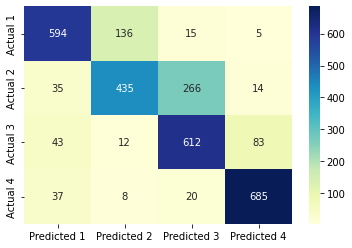

In [83]:
y_pred = model.predict(X_test_combined)
y_pred_inverse = one_hot_encoder.inverse_transform(y_pred)
cm = confusion_matrix(y_test, y_pred_inverse)

print('Confusion matrix for testing dataset\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Predicted 1', 'Predicted 2', 'Predicted 3' ,'Predicted 4'], 
                        index=['Actual 1', 'Actual 2', 'Actual 3' ,'Actual 4'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

### Approach 2:

### Use Keras embedding layer + glove embedding weights

In [4]:
from nltk.tokenize import word_tokenize

len_list = []
for d in tqdm(X_train):
    len_list.append(len(word_tokenize(d)))

100%|█████████████████████████████████████████████████████████████████████████| 48854/48854 [02:28<00:00, 328.76it/s]


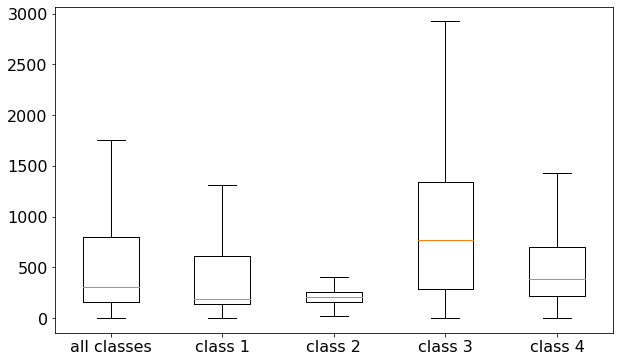

83 percentile:  1004.0


,all classes,class 1,class 2,class 3,class 4
count,48854.000000,14047.000000,6942.000000,17870.000000,9995.000000
mean,604.384104,338.721364,216.720542,1018.812759,506.043422
std,1071.811433,294.862339,89.790755,1638.129072,411.558255
min,2.000000,2.000000,2.000000,2.000000,2.000000
25%,161.000000,139.000000,162.000000,285.250000,219.000000
50%,307.000000,184.000000,207.000000,765.000000,389.000000
75%,799.000000,615.000000,259.000000,1341.000000,705.000000
max,131926.000000,2465.000000,2654.000000,131926.000000,5215.000000


In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


df = pd.DataFrame(list(zip(len_list, y_train)),
               columns =['length', 'class'])

arr1 = df.loc[df['class'] == 1]['length']
arr2 = df.loc[df['class'] == 2]['length']
arr3 = df.loc[df['class'] == 3]['length']
arr4 = df.loc[df['class'] == 4]['length']

fig, ax1 = plt.subplots(figsize=(10, 6)) 
plt.yticks(fontsize=16)
# Creating plot

ax1.boxplot([len_list, arr1, arr2, arr3, arr4], showfliers=False)
ax1.set_xticklabels(['all classes', 'class 1','class 2','class 3','class 4'], fontsize=16)
# show plot
plt.show()


df_describe = pd.concat([pd.DataFrame(len_list).describe(), \
                         pd.DataFrame(arr1).describe(), \
                         pd.DataFrame(arr2).describe(), \
                         pd.DataFrame(arr3).describe(), \
                         pd.DataFrame(arr4).describe()], axis=1)
df_describe.columns = ['all classes', 'class 1','class 2','class 3','class 4']
print("83 percentile: ",np.percentile(len_list, 83))

df_describe

In [140]:
from keras import layers

max_length=1000
vectorizer = layers.TextVectorization(max_tokens=20000, output_sequence_length=max_length)
vectorizer.adapt(X_train)

In [141]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [142]:
X_train_vector=vectorizer(X_train)
X_test_vector=vectorizer(X_test)

In [143]:
print(X_train_vector.shape)
print(X_train_vector[:2])

(48854, 1000)
tf.Tensor(
[[   6  226  310 ...    0    0    0]
 [   2 3946    4 ...    0    0    0]], shape=(2, 1000), dtype=int64)


In [113]:
embedding_dim = 100

glove_filename='glove.6B.' + str(embedding_dim) + 'd.txt'
glove_path = os.path.abspath(os.path.join('.', glove_filename))

embeddings_index = {}
with open(glove_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [114]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 19415 words (585 misses)


In [107]:
print(embedding_matrix.shape)

(20002, 200)


In [177]:
import keras
from keras.layers import Flatten,Embedding,GlobalAveragePooling1D
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam,Adagrad
import tensorflow_addons as tfa

epochs = 10

# define the model
model2 = Sequential()
model2.add(Embedding(num_tokens, embedding_dim, input_length=max_length, weights=[embedding_matrix]))
model2.add(GlobalAveragePooling1D())
# model.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.5))
# model2.add(Dense(16, activation='relu'))
# model2.add(Dropout(0.5))
model2.add(Dense(4, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy', tfa.metrics.F1Score(average='macro',num_classes=4)])
model2.summary()

checkpoint_filepath = 'checkpoint_model_nn2'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_f1_score',
    mode='max',
    save_best_only=True)

model2.fit(X_train_vector, y_train_labeled, epochs=epochs, validation_data=(X_test_vector, y_test_labeled),\
          callbacks=[model_checkpoint_callback])

model2.load_weights(checkpoint_filepath)
y_pred = model2.predict(X_test_vector)

y_pred_inverse = one_hot_encoder.inverse_transform(y_pred)

print(classification_report(y_test, y_pred_inverse))

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_60 (Embedding)    (None, 1000, 100)         2000200   
                                                                 
 global_average_pooling1d_3  (None, 100)               0         
 9 (GlobalAveragePooling1D)                                      
                                                                 
 dense_192 (Dense)           (None, 64)                6464      
                                                                 
 dropout_130 (Dropout)       (None, 64)                0         
                                                                 
 dense_193 (Dense)           (None, 32)                2080      
                                                                 
 dropout_131 (Dropout)       (None, 32)                0         
                                                     

INFO:tensorflow:Assets written to: checkpoint_model_nn2/assets


1527/1527 [==============================] - 33s 21ms/step - loss: 0.7056 - accuracy: 0.7277 - f1_score: 0.6774 - val_loss: 0.9390 - val_accuracy: 0.7190 - val_f1_score: 0.7018
Epoch 2/10
1525/1527 [============================>.] - ETA: 0s - loss: 0.2428 - accuracy: 0.9286 - f1_score: 0.9226INFO:tensorflow:Assets written to: checkpoint_model_nn2/assets


INFO:tensorflow:Assets written to: checkpoint_model_nn2/assets


1527/1527 [==============================] - 31s 20ms/step - loss: 0.2427 - accuracy: 0.9286 - f1_score: 0.9226 - val_loss: 0.9268 - val_accuracy: 0.7527 - val_f1_score: 0.7439
Epoch 3/10
1527/1527 [==============================] - 31s 20ms/step - loss: 0.1546 - accuracy: 0.9559 - f1_score: 0.9529 - val_loss: 1.4200 - val_accuracy: 0.7273 - val_f1_score: 0.7012
Epoch 4/10
1527/1527 [==============================] - 31s 20ms/step - loss: 0.1127 - accuracy: 0.9685 - f1_score: 0.9665 - val_loss: 1.5938 - val_accuracy: 0.7287 - val_f1_score: 0.7100
Epoch 5/10
1527/1527 [==============================] - 30s 20ms/step - loss: 0.0892 - accuracy: 0.9744 - f1_score: 0.9732 - val_loss: 1.5465 - val_accuracy: 0.7427 - val_f1_score: 0.7312
Epoch 6/10
1525/1527 [============================>.] - ETA: 0s - loss: 0.0776 - accuracy: 0.9783 - f1_score: 0.9773INFO:tensorflow:Assets written to: checkpoint_model_nn2/assets


INFO:tensorflow:Assets written to: checkpoint_model_nn2/assets


1527/1527 [==============================] - 31s 20ms/step - loss: 0.0777 - accuracy: 0.9783 - f1_score: 0.9773 - val_loss: 1.4777 - val_accuracy: 0.7640 - val_f1_score: 0.7575
Epoch 7/10
1527/1527 [==============================] - 31s 20ms/step - loss: 0.0655 - accuracy: 0.9823 - f1_score: 0.9814 - val_loss: 2.2288 - val_accuracy: 0.7410 - val_f1_score: 0.7271
Epoch 8/10
1527/1527 [==============================] - 31s 20ms/step - loss: 0.0596 - accuracy: 0.9839 - f1_score: 0.9832 - val_loss: 2.0459 - val_accuracy: 0.7607 - val_f1_score: 0.7509
Epoch 9/10
1527/1527 [==============================] - 33s 22ms/step - loss: 0.0527 - accuracy: 0.9855 - f1_score: 0.9851 - val_loss: 2.9110 - val_accuracy: 0.7297 - val_f1_score: 0.7076
Epoch 10/10
13/94 [===>..........................] - ETA: 0s

2024-03-31 00:29:11.189565: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open checkpoint_model_nn2: FAILED_PRECONDITION: checkpoint_model_nn2; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


94/94 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           1       0.86      0.86      0.86       750
           2       0.80      0.49      0.61       750
           3       0.63      0.80      0.70       750
           4       0.81      0.90      0.85       750

    accuracy                           0.76      3000
   macro avg       0.78      0.76      0.76      3000
weighted avg       0.78      0.76      0.76      3000



1527/1527 [==============================] - 5s 3ms/step
Confusion matrix for training dataset
 [[13976     7    55     9]
 [    6  6901    34     1]
 [   22    21 17822     5]
 [  119     9   194  9673]]


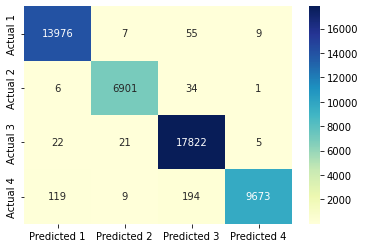

In [180]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model2.predict(X_train_vector)
y_pred_inverse = one_hot_encoder.inverse_transform(y_pred)
cm = confusion_matrix(y_train, y_pred_inverse)

print('Confusion matrix for training dataset\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Predicted 1', 'Predicted 2', 'Predicted 3' ,'Predicted 4'], 
                        index=['Actual 1', 'Actual 2', 'Actual 3' ,'Actual 4'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

94/94 [==============================] - 0s 3ms/step
Confusion matrix for testing dataset
 [[645  68  16  21]
 [ 32 369 313  36]
 [ 35  15 603  97]
 [ 35   9  31 675]]


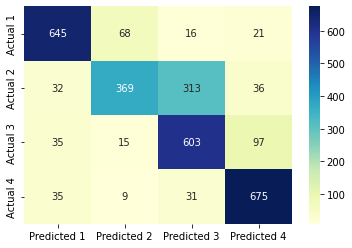

In [181]:
y_pred = model2.predict(X_test_vector)
y_pred_inverse = one_hot_encoder.inverse_transform(y_pred)
cm = confusion_matrix(y_test, y_pred_inverse)

print('Confusion matrix for testing dataset\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Predicted 1', 'Predicted 2', 'Predicted 3' ,'Predicted 4'], 
                        index=['Actual 1', 'Actual 2', 'Actual 3' ,'Actual 4'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()